Generación 1, Mejor fitness: 0.9666, Promedio características: 16.40, Fitness promedio seleccionados: 0.9589
Generación 2, Mejor fitness: 0.9666, Promedio características: 16.00, Fitness promedio seleccionados: 0.9573
Generación 3, Mejor fitness: 0.9649, Promedio características: 16.45, Fitness promedio seleccionados: 0.9589
Generación 4, Mejor fitness: 0.9684, Promedio características: 16.10, Fitness promedio seleccionados: 0.9608
Generación 5, Mejor fitness: 0.9666, Promedio características: 16.10, Fitness promedio seleccionados: 0.9593
Generación 6, Mejor fitness: 0.9666, Promedio características: 16.30, Fitness promedio seleccionados: 0.9614
Generación 7, Mejor fitness: 0.9684, Promedio características: 15.40, Fitness promedio seleccionados: 0.9611
Generación 8, Mejor fitness: 0.9719, Promedio características: 14.90, Fitness promedio seleccionados: 0.9628
Generación 9, Mejor fitness: 0.9684, Promedio características: 15.05, Fitness promedio seleccionados: 0.9618
Generación 10, Mejo

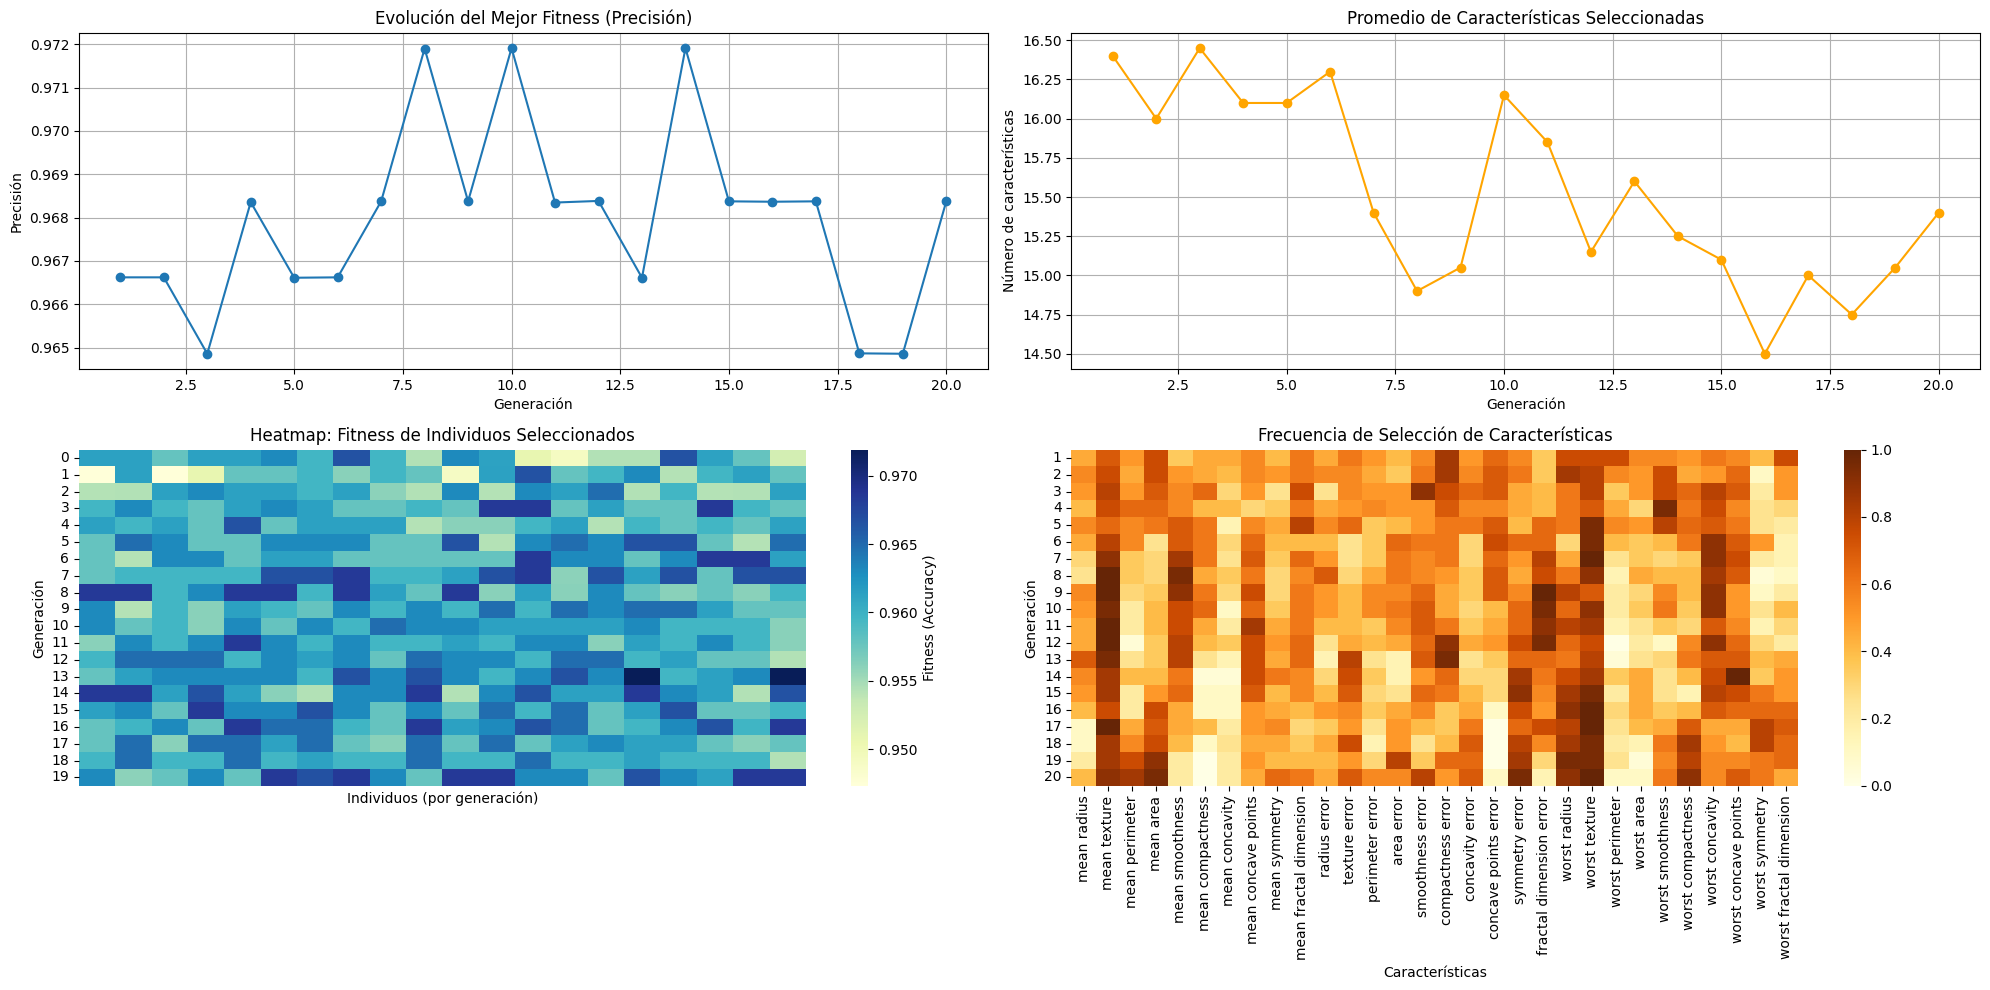

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Cargar datos
data = load_breast_cancer()
X = data.data
y = data.target
n_features = X.shape[1]
feature_names = data.feature_names  # Nombres de las características

# Parámetros AG
population_size = 20
generations = 20
mutation_rate = 0.1

# Crear población inicial (vector binario)
def create_population():
    return np.random.randint(0, 2, size=(population_size, n_features))

# Fitness: precisión promedio en CV con características seleccionadas
def fitness(chromosome):
    if np.sum(chromosome) == 0:
        return 0  # Evitar cromosomas sin características
    X_selected = X[:, chromosome == 1]
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    score = cross_val_score(clf, X_selected, y, cv=3).mean()
    return score

# Selección (torneo)
def selection(pop, fitnesses):
    selected = []
    selected_fitnesses = []
    for _ in range(population_size):
        i, j = np.random.choice(population_size, 2, replace=False)
        if fitnesses[i] > fitnesses[j]:
            selected.append(pop[i])
            selected_fitnesses.append(fitnesses[i])
        else:
            selected.append(pop[j])
            selected_fitnesses.append(fitnesses[j])
    return np.array(selected), np.array(selected_fitnesses)

# Cruzamiento (single point)
def crossover(parent1, parent2):
    point = np.random.randint(1, n_features - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

# Mutación
def mutate(chromosome):
    for i in range(n_features):
        if np.random.rand() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# Inicializar
population = create_population()

best_fitness_history = []
avg_features_selected_history = []
selected_fitness_history = []
selected_fitness_matrix = []
feature_selection_freq = np.zeros((generations, n_features))  # Para contar selección de características

for gen in range(generations):
    fitnesses = np.array([fitness(ind) for ind in population])
    best_fitness = fitnesses.max()
    best_fitness_history.append(best_fitness)

    avg_features = np.mean([np.sum(ind) for ind in population])
    avg_features_selected_history.append(avg_features)

    selected, selected_fitnesses = selection(population, fitnesses)
    selected_fitness_history.append(selected_fitnesses.mean())
    selected_fitness_matrix.append(selected_fitnesses)

    # Contar frecuencia de selección de características
    feature_selection_freq[gen] = np.mean(selected, axis=0)

    print(f"Generación {gen+1}, Mejor fitness: {best_fitness:.4f}, "
          f"Promedio características: {avg_features:.2f}, "
          f"Fitness promedio seleccionados: {selected_fitnesses.mean():.4f}")

    # Reproducir
    next_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected[i], selected[i+1]
        child1, child2 = crossover(parent1, parent2)
        next_population.append(mutate(child1))
        next_population.append(mutate(child2))
    population = np.array(next_population)

# Mejor solución
fitnesses = np.array([fitness(ind) for ind in population])
best_idx = np.argmax(fitnesses)
best_chromosome = population[best_idx]

print("\n=== MEJOR CONJUNTO DE CARACTERÍSTICAS ===")
selected_indices = np.where(best_chromosome == 1)[0]
print("Índices:", selected_indices)
print("Características seleccionadas:")
for i in selected_indices:
    print(f"- {feature_names[i]}")
print(f"Precisión obtenida: {fitnesses[best_idx]:.4f}")

# Convertir listas a matrices
selected_fitness_matrix = np.array(selected_fitness_matrix)

# === GRAFICOS ===
plt.figure(figsize=(20, 10))

# Mejor precisión
plt.subplot(2, 2, 1)
plt.plot(range(1, generations+1), best_fitness_history, marker='o')
plt.title("Evolución del Mejor Fitness (Precisión)")
plt.xlabel("Generación")
plt.ylabel("Precisión")
plt.grid(True)

# Características seleccionadas
plt.subplot(2, 2, 2)
plt.plot(range(1, generations+1), avg_features_selected_history, marker='o', color='orange')
plt.title("Promedio de Características Seleccionadas")
plt.xlabel("Generación")
plt.ylabel("Número de características")
plt.grid(True)

# HEATMAP de fitness de seleccionados
plt.subplot(2, 2, 3)
sns.heatmap(selected_fitness_matrix, cmap="YlGnBu",
            cbar_kws={'label': 'Fitness (Accuracy)'}, xticklabels=False)
plt.title("Heatmap: Fitness de Individuos Seleccionados")
plt.xlabel("Individuos (por generación)")
plt.ylabel("Generación")

# HEATMAP de selección de características
plt.subplot(2, 2, 4)
sns.heatmap(feature_selection_freq, cmap="YlOrBr",
            xticklabels=feature_names, yticklabels=np.arange(1, generations+1))
plt.xticks(rotation=90)
plt.title("Frecuencia de Selección de Características")
plt.xlabel("Características")
plt.ylabel("Generación")

plt.tight_layout()
plt.show()
